In [1]:
import os

from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from io import BytesIO
from tensorflow.python.lib.io import file_io
from tensorflow.keras.layers import (
    Conv3D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling3D,
    Softmax
)

In [2]:
%%bash
PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT


Your current GCP Project Name is: qwiklabs-asl-04-76d2f9d7a5ae


In [3]:
PROJECT = !gcloud config list --format 'value(core.project)'
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

In [4]:
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


In [6]:
labels_to_numeric = {
    "Arterial": 0,
    "Late": 1,
    "Non-Contrast": 2,
    "Venous": 3
}

numeric_to_labels = {
    0:   "Arterial",
    1:   "Late",    
    2:   "Non-Contrast",    
    3:  "Venous"
}

def reshape_and_normalize(images):
    
    ### START CODE HEREA

    # Reshape the images to add an extra dimension
    images = images.reshape((images.shape[0], images.shape[1], images.shape[2], images.shape[3],1))
    
    # Normalize pixel values
    max_value = np.max(images)
    images = images/max_value
    
    ### END CODE HERE

    return images,max_value# Reload the images in case you run this cell multiple times

def load_and_format_data_from_gcs(sample_dir):
    # sample_dir="gs://capstone-datasets/train_3d.csv"
    file_list = file_io.read_file_to_string(sample_dir).split("\n")
    images = np.array([np.load(BytesIO(file_io.read_file_to_string(file, binary_mode=True)))
                      for file in file_list if file])
    labels = np.array([os.path.basename(file).split("_")[4] for file in file_list if file])
    labels = np.array([labels_to_numeric[label] for label in labels])
    one_hots = to_categorical(labels)

    images_tranformed, max_value = reshape_and_normalize(images)
    return images_tranformed, one_hots

In [7]:
#Create Test Dataset
test_sample_dir = "gs://capstone-datasets/test_3d.csv"
test_images, one_hots = load_and_format_data_from_gcs(test_sample_dir)

In [8]:
img = test_images[1].astype(np.float32).tolist()

In [9]:
# #Create test json file
# BATCH_PREDICTION_INSTANCES_FILE = "auto.jsonl"

# with open(BATCH_PREDICTION_INSTANCES_FILE, "w") as f:
#     for i in range (len(test_images)):
#         f.write(json.dumps(test_images[i].tolist()) + "\n")

In [10]:
# os.chdir('/home/jupyter/CapStone_Phase_Contrast/src/')

In [11]:
# Push json file to GCS Bucket
# !gsutil cp auto.jsonl gs://capstone-datasets/image_all.jsonl

In [12]:
# # Rutu's model_all image
# MODEL_RESOURCENAME = "projects/146339387885/locations/us-central1/models/3863536525446742016"

# aiplatform.init(project=PROJECT, location=REGION)

# my_model = aiplatform.Model(MODEL_RESOURCENAME)

# batch_prediction_job = my_model.batch_predict(
#     job_display_name="ct_scan_batch_kamrul_predict_rutusmodel2",
#     gcs_source=f"gs://capstone-datasets/image_all.jsonl",
#     gcs_destination_prefix=f"gs://{BUCKET}/ct_contrast_outputs/Rutu/",
#     machine_type="n1-highcpu-32",
#     accelerator_type="NVIDIA_TESLA_T4",
#     starting_replica_count=1,
#     max_replica_count=1,
#     accelerator_count=1,
# )

# batch_prediction_job.wait()

# print(batch_prediction_job.display_name)
# print(batch_prediction_job.resource_name)
# print(batch_prediction_job.state)

In [13]:
#Check for errors
# !gsutil cat $(gsutil ls gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5 | tail -n1)prediction.errors_stats-*

In [14]:
# !gsutil cat $(gsutil ls gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5 | tail -n1)prediction.results-*

In [26]:
import os
os.chdir('/home/jupyter/CapStone_Phase_Contrast/src/predictions/')

In [27]:
# #Push results to notebook
# !gsutil -m cp -r gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-* .

Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00000-of-00006...
Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00001-of-00006...
Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00002-of-00006...
Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00005-of-00006...
Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00003-of-00006...
Copying gs://qwiklabs-asl-04-76d2f9d7a5ae/ct_contrast_outputs5/prediction-rutu-test-2023_04_06T09_18_53_923Z/prediction.results-00004-of-00006...
| [6/6 files][358.6 MiB/358.6 MiB] 100% Done                                    
Operation completed over 6 objects/358.6 Mi

In [28]:
import json
import numpy as np
predictions=[]
predictions_numeric=[]
for filename in sorted(os.listdir()):
    f = os.path.join('/home/jupyter/CapStone_Phase_Contrast/src/predictions', filename)
    print(f)
    if os.path.isfile(f):
        results = []
        with open(f, "r") as file:
            results.extend([json.loads(line) for line in file.readlines()])
            for i in range(max(np.shape(results))):
                array=list(results[i]['prediction'])
                output=np.argmax(array)
                predictions.append(list(labels_to_numeric.keys()) [list(labels_to_numeric.values()).index(output)])
                predictions_numeric.append(output)
# predictions
# predictions_numeric

/home/jupyter/CapStone_Phase_Contrast/src/predictions/.ipynb_checkpoints
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00000-of-00006
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00001-of-00006
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00002-of-00006
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00003-of-00006
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00004-of-00006
/home/jupyter/CapStone_Phase_Contrast/src/predictions/prediction.results-00005-of-00006


In [18]:
# predictions

In [19]:
# !gsutil cp -r gs://test-3d-npy .

In [29]:
os.chdir('/home/jupyter/CapStone_Phase_Contrast/src/test-3d-npy')

In [30]:
ground_truth=[]
ground_truth_numeric=[]
for filename in sorted(os.listdir('/home/jupyter/CapStone_Phase_Contrast/src/test-3d-npy')):
    print(filename)
    newfile=filename.split('_')[4]
    ground_truth.append(newfile)
    ground_truth_numeric.append(labels_to_numeric[newfile])
# ground_truth    
# ground_truth_numeric

data_3D_test_10_Venous_0.npy
data_3D_test_25_Venous_0.npy
data_3D_test_35_Venous_0.npy
data_3D_test_40_Venous_0.npy
data_3D_test_KiTS-00011_Non-Contrast_0.npy
data_3D_test_KiTS-00015_Non-Contrast_0.npy
data_3D_test_KiTS-00017_Arterial_0.npy
data_3D_test_KiTS-00022_Non-Contrast_0.npy
data_3D_test_KiTS-00023_Non-Contrast_0.npy
data_3D_test_KiTS-00025_Late_0.npy
data_3D_test_KiTS-00036_Arterial_0.npy
data_3D_test_KiTS-00037_Arterial_0.npy
data_3D_test_KiTS-00040_Non-Contrast_0.npy
data_3D_test_KiTS-00042_Arterial_0.npy
data_3D_test_KiTS-00048_Arterial_0.npy
data_3D_test_KiTS-00056_Arterial_0.npy
data_3D_test_KiTS-00063_Arterial_0.npy
data_3D_test_KiTS-00073_Arterial_0.npy
data_3D_test_KiTS-00081_Arterial_0.npy
data_3D_test_KiTS-00084_Arterial_0.npy
data_3D_test_KiTS-00096_Arterial_0.npy
data_3D_test_KiTS-00096_Non-Contrast_0.npy
data_3D_test_KiTS-00097_Arterial_0.npy
data_3D_test_KiTS-00100_Arterial_0.npy
data_3D_test_KiTS-00100_Late_0.npy
data_3D_test_KiTS-00105_Arterial_0.npy
data_3D_te

In [31]:
# ground_truth  

[[7 8 4 2]
 [4 1 4 0]
 [5 3 1 1]
 [1 2 1 0]]


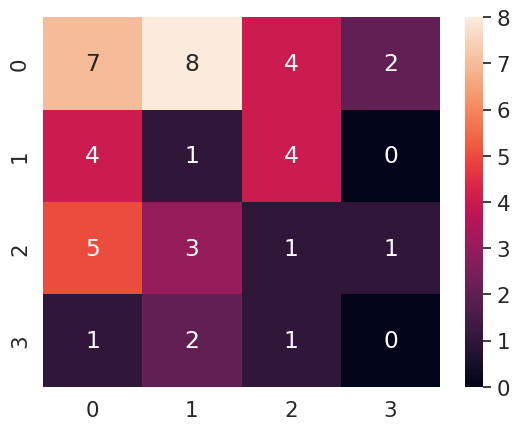

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(ground_truth_numeric, predictions_numeric)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)
categories = ['Arterial', 'Late', 'Non-Contrast', 'Venous']


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

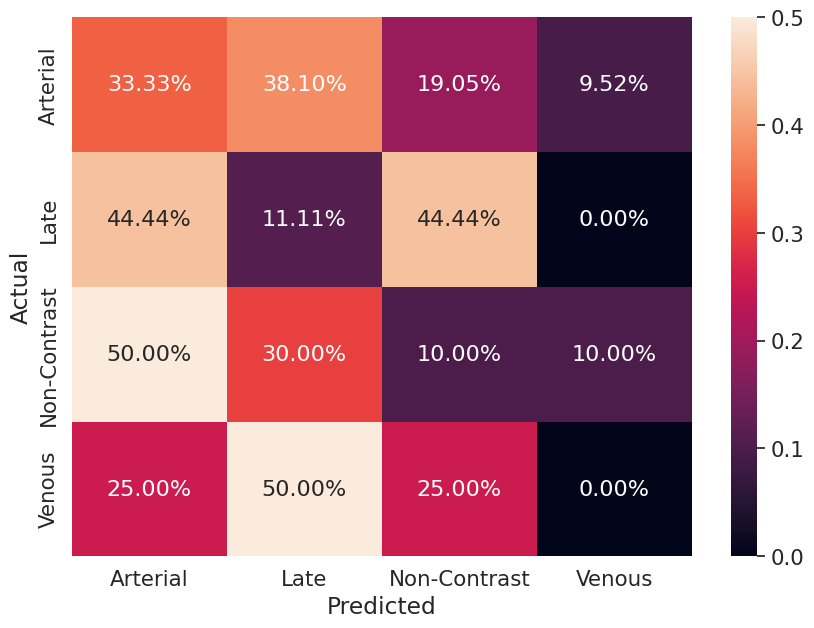

In [44]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# data = cf_matrix/cf_matrix.sum(axis=1)
data = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(data, columns=np.unique(categories), index = np.unique(categories))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, fmt='.02%', annot=True, annot_kws={"size": 16})# font size

In [34]:
from sklearn.metrics import *
accuracy = accuracy_score(ground_truth_numeric, predictions_numeric)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ground_truth_numeric, predictions_numeric, average=None)
print('Precision')
print(  precision)
# recall: tp / (tp + fn)
recall = recall_score(ground_truth_numeric, predictions_numeric,average=None)
print('Recall')
print( recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ground_truth_numeric, predictions_numeric, average=None)
print('F1 Score')
print( f1)

Accuracy: 0.204545
Precision
[0.41176471 0.07142857 0.1        0.        ]
Recall
[0.33333333 0.11111111 0.1        0.        ]
F1 Score
[0.36842105 0.08695652 0.1        0.        ]


In [46]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(ground_truth_numeric, predictions_numeric)

In [48]:
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.41176471 0.07142857 0.1        0.        ]
recall: [0.33333333 0.11111111 0.1        0.        ]
fscore: [0.36842105 0.08695652 0.1        0.        ]
support: [21  9 10  4]
